In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy
print("gammapy:", gammapy.__version__)

gammapy: 0.18.2


In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker, FoVBackgroundMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 25.0 * u.hr
l = 0.1
pointing = SkyCoord(141.409467, 40.566962, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(141.409467, 40.566962),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

In [8]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
#spectral_model = PowerLawSpectralModel(
#    index=2.22, amplitude="1.289e-12 cm-2 s-1 TeV-1", reference="1 TeV"
#)

spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.495, amplitude="2.72e-13 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=l * u.Unit("TeV-1"), alpha = 1
)


model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.495              
    amplitude               :   2.72e-13  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.100  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [9]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
dataset.models = models
dataset.fake(random_state=42)
print(dataset)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51545.04
	duration          : 90000.00 s
	pointing (icrs)   : 149.0 deg, 69.7 deg

	deadtime fraction : 0.0%

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 679175.21
  Predicted background counts     : 677717.46
  Predicted excess counts         : 1457.75

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1462699.45

  Number of models                : 2 
  Number of parameters            : 10
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      :

In [10]:
dataset1 = dataset.copy()
dataset1.models = bkg_model
print(dataset1)

MapDataset
----------

  Name                            : vItGobHg 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 677717.46
  Predicted background counts     : 677717.46
  Predicted excess counts         : nan

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1461707.09

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  


In [11]:
dataset2 = dataset.copy()
dataset2.models = bkg_model
print(dataset2)

MapDataset
----------

  Name                            : W5MK3Y_w 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 677717.46
  Predicted background counts     : 677717.46
  Predicted excess counts         : nan

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1461707.09

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  


In [12]:
geom_image = geom.to_image().to_cube([energy_reco.squash()])
regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [13]:
dataset1 = maker_fov.run(dataset1)
print(dataset1)

MapDataset
----------

  Name                            : vItGobHg 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 677911.73
  Predicted background counts     : 677911.73
  Predicted excess counts         : 0.00

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1461707.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : vItGobHg-bkg
    Datasets names            : ['vItGobHg']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt

In [14]:
dataset2 = maker_fov.run(dataset2)
print(dataset2)

MapDataset
----------

  Name                            : W5MK3Y_w 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 677911.73
  Predicted background counts     : 677911.73
  Predicted excess counts         : 0.00

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1461707.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : W5MK3Y_w-bkg
    Datasets names            : ['W5MK3Y_w']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt

In [15]:
spatial_model_1 = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
spectral_model_1 = ExpCutoffPowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=0 * u.Unit("TeV-1"), alpha = 1
)
model_simu_1 = SkyModel(
    spatial_model=spatial_model_1,
    spectral_model=spectral_model_1,
    name="model-simu",
)

bkg_model_1 = FoVBackgroundModel(dataset_name="dataset-simu")

models_1 = Models([model_simu_1, bkg_model_1])
print(models_1)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   3.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.000  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [16]:
TS0 = dataset1.stat_sum()
print(TS0)
models_fit = model_simu.copy()
models_fit_1 = model_simu.copy()
dataset1.models = models_fit
dataset2.models = models_fit_1
print(dataset1)
print(dataset2)

-1461707.9510226795
MapDataset
----------

  Name                            : vItGobHg 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 679175.21
  Predicted background counts     : 677717.46
  Predicted excess counts         : 1457.75

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1462699.45

  Number of models                : 1 
  Number of parameters            : 7
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : l-LAvy6m
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type 

In [17]:
%%time
dataset1.models.parameters['lambda_'].frozen = True
fit = Fit([dataset1])
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 105
	total stat : -1462705.77

CPU times: user 4.7 s, sys: 120 ms, total: 4.82 s
Wall time: 4.82 s


In [18]:
print(result.parameters.to_table())

   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index 2.5674e+00                       nan       nan  False 4.422e-02
amplitude 2.5262e-13 cm-2 s-1 TeV-1        nan       nan  False 1.351e-14
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
  lambda_ 1.0000e-01          TeV-1        nan       nan   True 0.000e+00
    alpha 1.0000e+00                       nan       nan   True 0.000e+00
    lon_0 1.4140e+02            deg        nan       nan  False 2.793e-03
    lat_0 4.0566e+01            deg -9.000e+01 9.000e+01  False 2.145e-03


In [19]:
TS1 = dataset1.stat_sum()
del_TS = TS0 - TS1
print(del_TS)

997.819155172212


In [20]:
print(dataset1)
print(dataset2)

MapDataset
----------

  Name                            : vItGobHg 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 679190.16
  Predicted background counts     : 677717.46
  Predicted excess counts         : 1472.71

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1462705.77

  Number of models                : 1 
  Number of parameters            : 7
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : l-LAvy6m
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Paramet

In [21]:
%%time
dataset2.models.parameters['lambda_'].frozen = False
fit = Fit([dataset2])
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 157
	total stat : -1462706.02

CPU times: user 5.59 s, sys: 148 ms, total: 5.74 s
Wall time: 5.73 s


In [22]:
print(result.parameters.to_table())

   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index 2.5317e+00                       nan       nan  False 8.731e-02
amplitude 2.6724e-13 cm-2 s-1 TeV-1        nan       nan  False 3.422e-14
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
  lambda_ 1.3589e-01          TeV-1        nan       nan  False 7.176e-02
    alpha 1.0000e+00                       nan       nan   True 0.000e+00
    lon_0 1.4140e+02            deg        nan       nan  False 2.788e-03
    lat_0 4.0566e+01            deg -9.000e+01 9.000e+01  False 2.142e-03


In [23]:
TS2 = dataset2.stat_sum()
del_TS_1 = TS1 - TS2
del_TS_2 = TS0 - TS2
print(del_TS_1)
print(del_TS_2)

0.24929544352926314
998.0684506157413


In [24]:
print(dataset2)

MapDataset
----------

  Name                            : W5MK3Y_w 

  Total counts                    : 679317 
  Total background counts         : 677717.46
  Total excess counts             : 1599.54

  Predicted counts                : 679181.63
  Predicted background counts     : 677717.46
  Predicted excess counts         : 1464.17

  Exposure min                    : 1.28e+10 m2 s
  Exposure max                    : 3.26e+11 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1462706.02

  Number of models                : 1 
  Number of parameters            : 7
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : o1brJmBH
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Paramet

In [25]:
spec = models_fit.spectral_model

In [26]:
energy_edges = np.logspace(-1.0, 1.0, 5) * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges)

In [27]:
%%time
flux_points = fpe.run(datasets=[dataset1])

CPU times: user 4.6 s, sys: 35.7 ms, total: 4.63 s
Wall time: 4.63 s


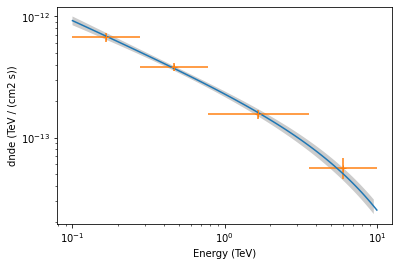

In [28]:
energy_range = [0.1, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

In [29]:
def flux_plt(model, dataset):
    spec = model.spectral_model
    energy_edges = np.logspace(-1.0, 1.0, 5) * u.TeV
    fpe = FluxPointsEstimator(energy_edges=energy_edges)
    flux_points = fpe.run(datasets=[dataset])
    energy_range = [0.1, 10] * u.TeV
    spec.plot(energy_range=energy_range, energy_power=2)
    ax = spec.plot_error(energy_range=energy_range, energy_power=2)
    flux_points.plot(ax=ax, energy_power=2)
    plt.title("Livetime = "+str(dataset.gti.time_delta.to(u.hr)))#, fontsize='15')
    return

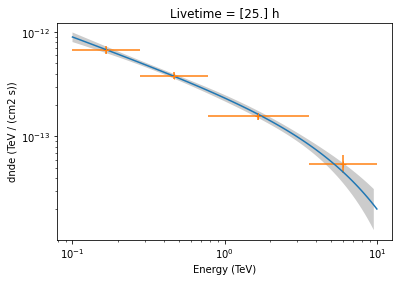

In [30]:
flux_plt(models_fit_1, dataset2)